Grand comparison of different noise levels, sample sizes and distance metrics

In [1]:

from typing import List
import mhn

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.spatial
import scipy.cluster
import RandomMHNGenerator as rmg
import ClusterableMhnGenerator as cmg
import EventDistanceMeasurer as edm
import mhn_tools

c:\Users\michi\Desktop\Uni\Bachelorarbeit\ws24_mbonart_mhn-feature-clustering\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


loading from mbonart_checkpoints/rmg1/mhn_SET
loading from mbonart_checkpoints/rmg1/mhn_TRAINED


(<matplotlib.image.AxesImage at 0x1de451fe3c0>,
 <matplotlib.colorbar.Colorbar at 0x1de446e3980>)

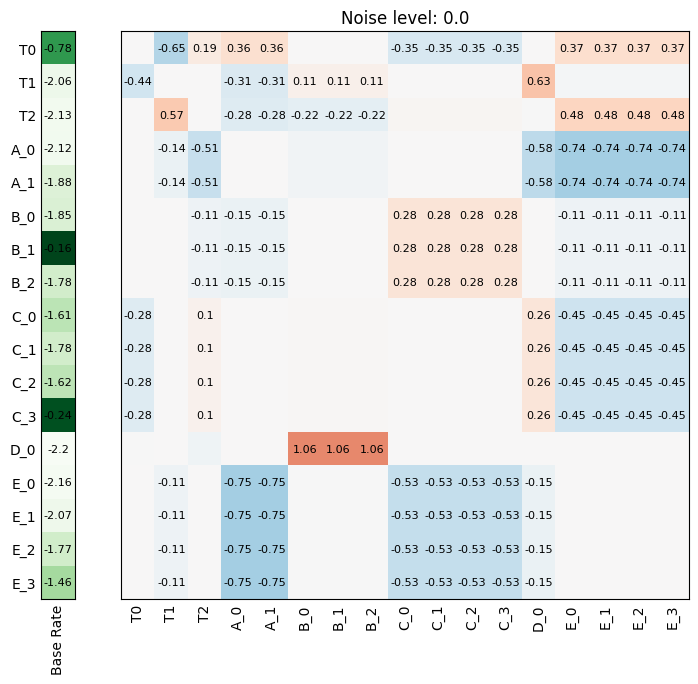

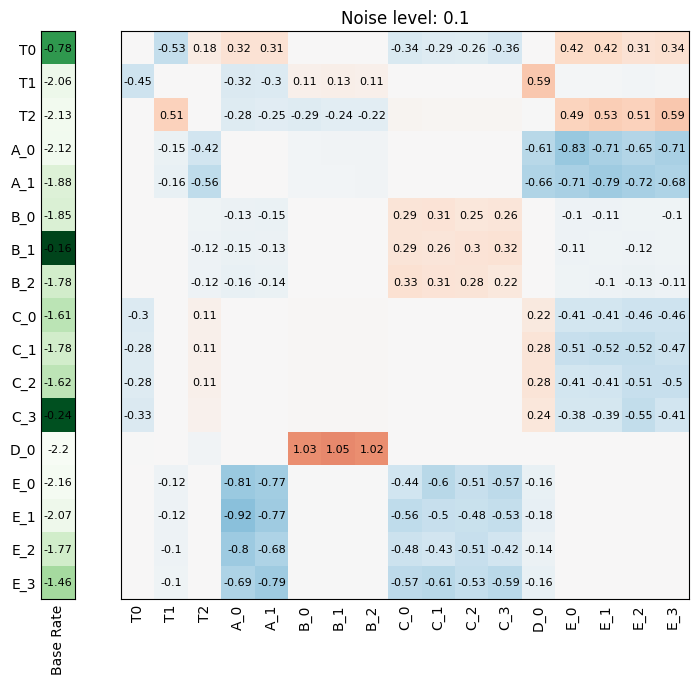

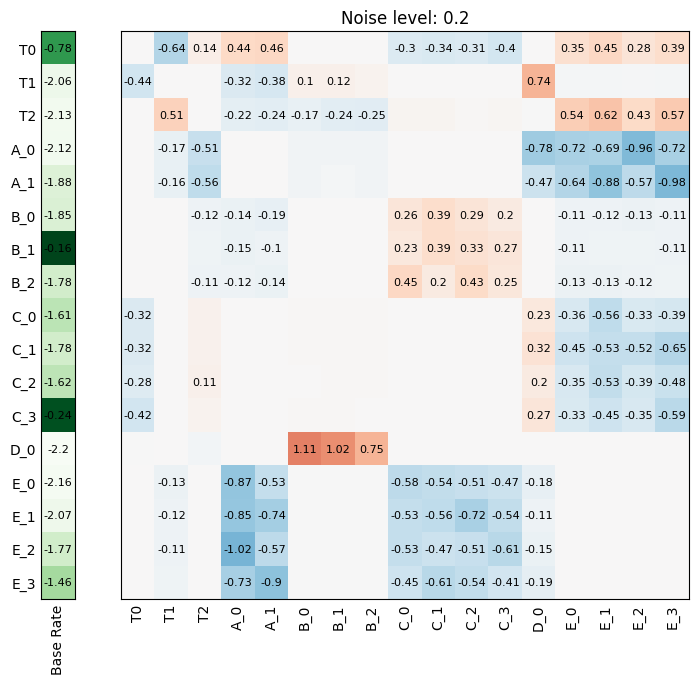

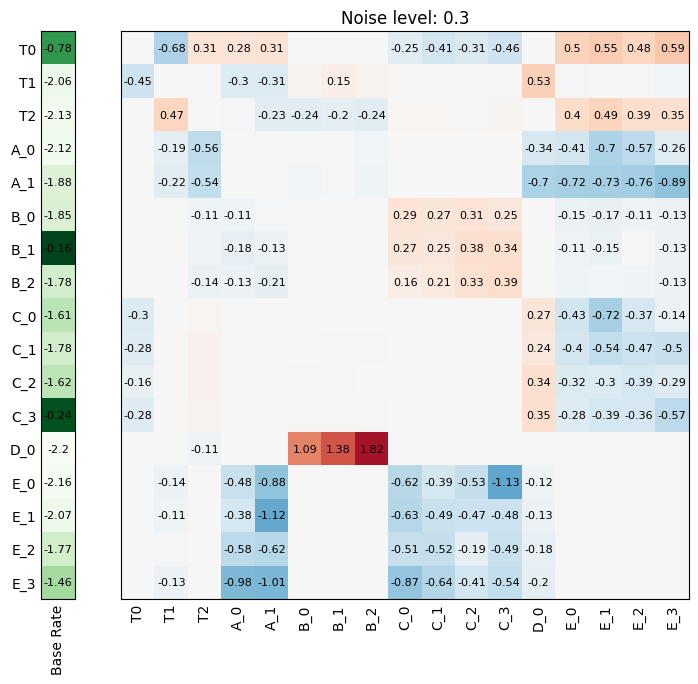

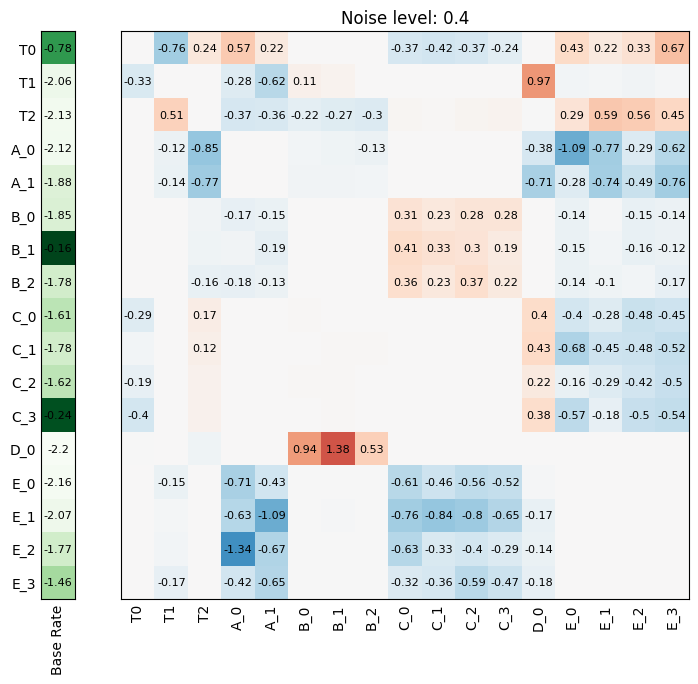

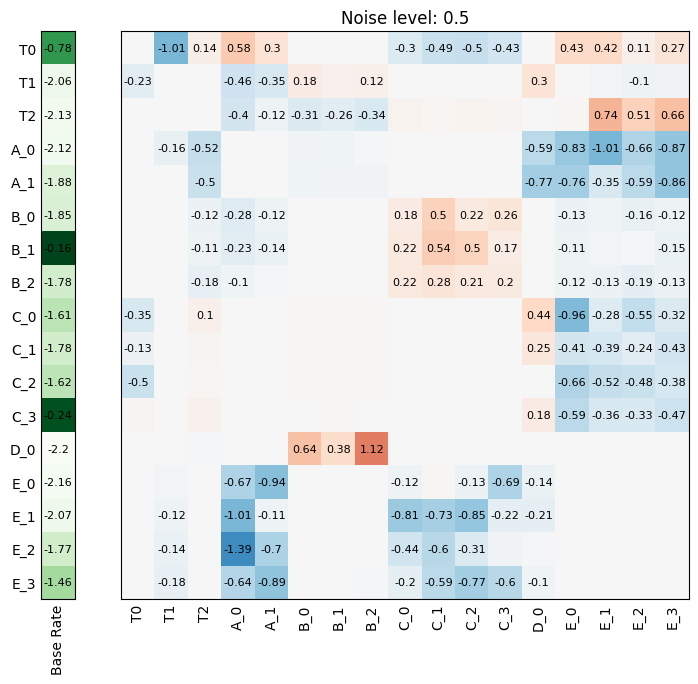

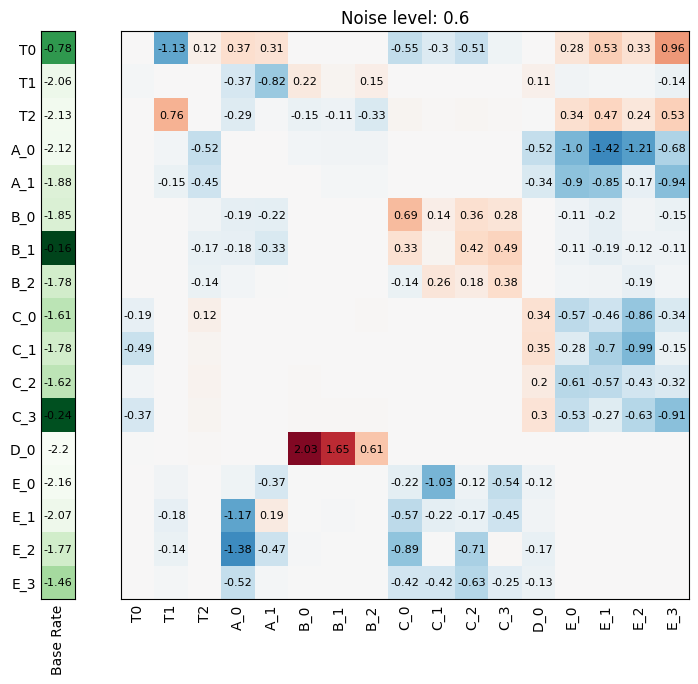

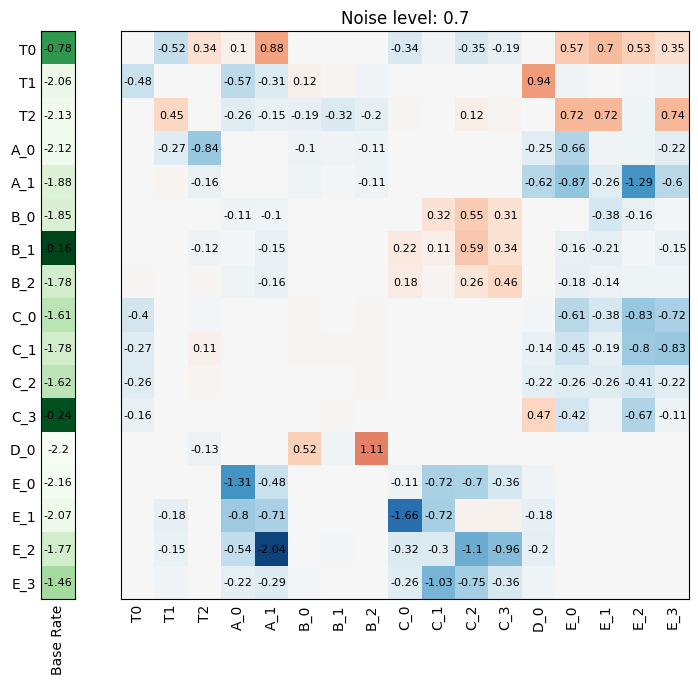

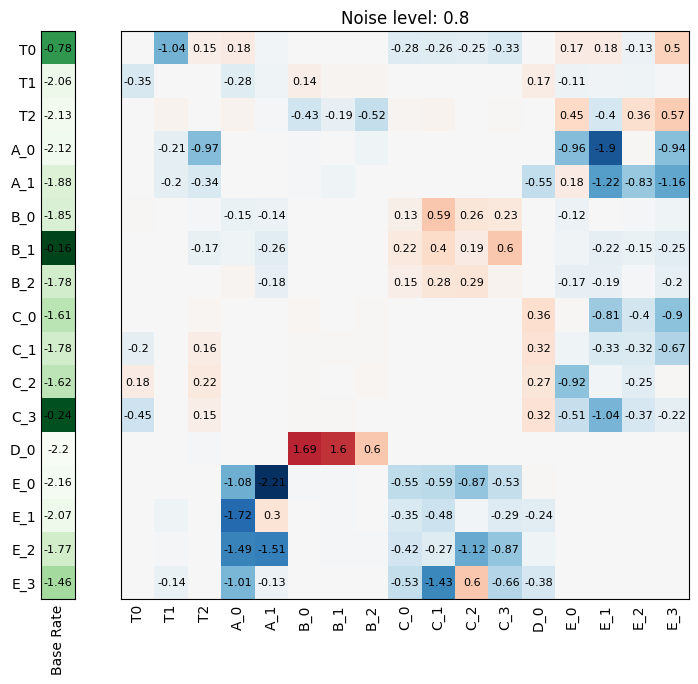

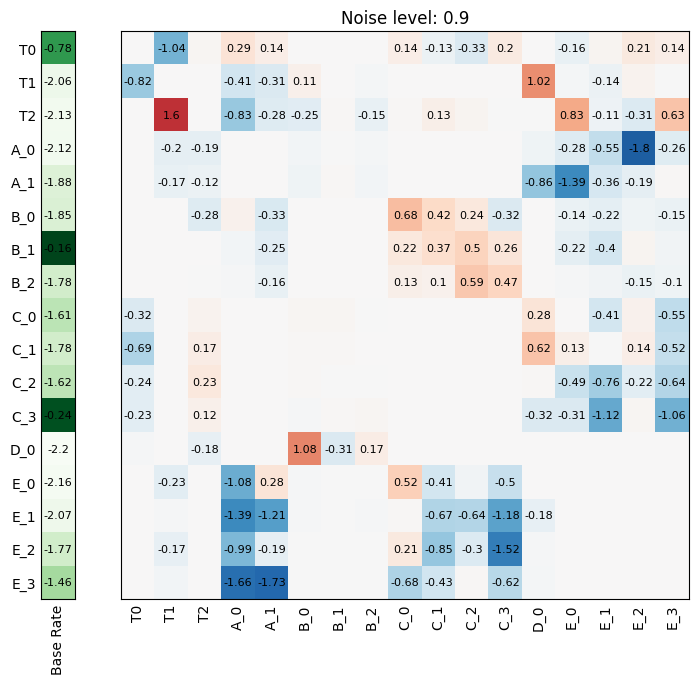

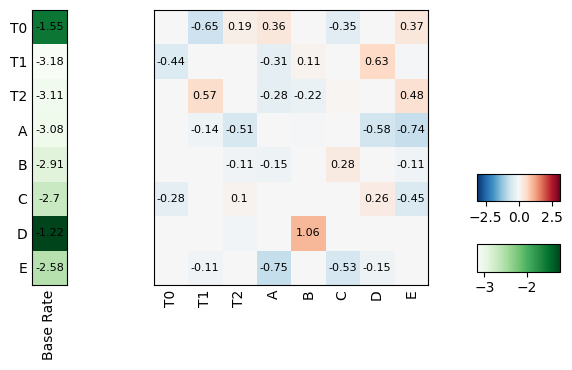

In [2]:
np.random.seed(12345)

cl_generator = cmg.ClusterableMhnGenerator(3,5)
rand_generator = rmg.RandomMHNGenerator(cl_generator.getEvents())
rand_generator.loadfrom("mbonart_checkpoints/rmg1")
cl_generator.setClusterMHN(rand_generator.getMHN())
given_clustersizes=[2,3,4,1,4]
cl_generator.splitClusters(given_clustersizes)
cl_generator.randomizeBaseRates() 

test_events = cl_generator.getEvents(cmg.DOM.TEST)
events = cl_generator.getEvents(cmg.DOM.CLUSTER)


noise_levels=[i/10 for i in range(10)]
sample_sizes=[1000, 2500, 7500, 20000, 50000, 100000]

np.random.seed(31415)
#np.random.seed(3)   #TODO: implement seeded experiment system
noisy_mhns: List[mhn.model.cMHN] = [cl_generator.get_noisy_MHN(amplitude= noise_level) for noise_level in noise_levels]

sampled_datas :List[List[pd.DataFrame]]=[]
sampled_datas=[[noisy_mhn.sample_artificial_data(sample_size, as_dataframe=True) for sample_size in sample_sizes] for noisy_mhn in noisy_mhns]
    

for nl, noisy_mhn in zip(noise_levels,noisy_mhns):
    noisy_mhn.plot(colorbar=False)
    plt.title(f"Noise level: {nl}")

rand_generator.getMHN().plot()

Train all EventDistanceMeasurers

In [3]:
all_dist_measurers:List[List[edm.EventDistanceMeasurer]] = [[edm.getDistMeasurer(sampled_data, cut_first_col=False) for sampled_data in row] for row in sampled_datas]


0x1.0bc8a665f87bbp+62
Directory for storage is edm_0bc8a665f87bb/T0_T1_T2
check if mbonart_checkpoints/edm_0bc8a665f87bb/T0_T1_T2   does exist
0x1.a122e7fdede17p+63
Directory for storage is edm_a122e7fdede17/T0_T1_T2
check if mbonart_checkpoints/edm_a122e7fdede17/T0_T1_T2   does exist
0x1.62c1a65641caep+60
Directory for storage is edm_62c1a65641cae/T0_T1_T2
check if mbonart_checkpoints/edm_62c1a65641cae/T0_T1_T2   does exist
0x1.bb8ccb1daf129p+62
Directory for storage is edm_bb8ccb1daf129/T0_T1_T2
check if mbonart_checkpoints/edm_bb8ccb1daf129/T0_T1_T2   does exist
0x1.be3c7defd1bacp+63
Directory for storage is edm_be3c7defd1bac/T0_T1_T2
check if mbonart_checkpoints/edm_be3c7defd1bac/T0_T1_T2   does exist
0x1.9287a21fc455dp+58
Directory for storage is edm_9287a21fc455d/T0_T1_T2
check if mbonart_checkpoints/edm_9287a21fc455d/T0_T1_T2   does exist
0x1.ae3ce67000ff4p+62
Directory for storage is edm_ae3ce67000ff4/T0_T1_T2
check if mbonart_checkpoints/edm_ae3ce67000ff4/T0_T1_T2   does exist

In [4]:
for row in all_dist_measurers:
    for dist_measurer in row:
        dist_measurer.compute_distance_matrix(edm.DIST.OFFDIAG_L1_SYM)

In [13]:
cluster_size_range=[5]#[4,5,6]
#cluster_size_range=range(14)
all_linkages=[[scipy.cluster.hierarchy.linkage(dist_measurer._dist_mat, method="single") for dist_measurer in row] for row in all_dist_measurers]
all_cut_trees=[[[np.concatenate(scipy.cluster.hierarchy.cut_tree(linkage, n_clusters=n_clusters)) for n_clusters in cluster_size_range] for linkage in row] for row in all_linkages]

C:\Users\michi\AppData\Local\Temp\ipykernel_27584\2877682654.py:3: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  all_linkages=[[scipy.cluster.hierarchy.linkage(dist_measurer._dist_mat, method="single") for dist_measurer in row] for row in all_dist_measurers]


In [14]:
from sklearn.metrics.cluster import adjusted_rand_score

cluster_solution=np.concatenate([[i]*c_size for i, c_size in enumerate(given_clustersizes)])

all_ar_scores=[[[adjusted_rand_score(cluster_solution,cut_tree) for cut_tree in l] for l in row] for row in all_cut_trees]
all_mean_ar_scores=[[np.mean(l) for l in row] for row in all_ar_scores]
all_max_ar_scores=[[np.max(l) for l in row] for row in all_ar_scores]
all_sum_ar_scores=[[np.sum(l) for l in row] for row in all_ar_scores]

Text(50.722222222222214, 0.5, 'Noise-level')

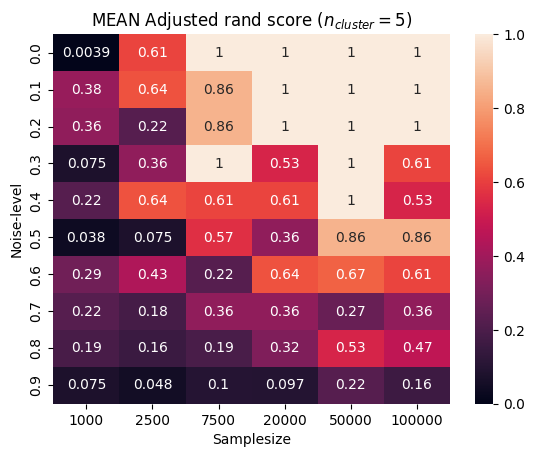

In [15]:
sns.heatmap(all_mean_ar_scores,vmin=0,vmax=1, xticklabels=sample_sizes, yticklabels=noise_levels, annot=True)
#plt.title("MEAN of Adjusted rand scores  $(n_{cluster} \in \{4,5,6\})$")
#plt.title("Adjusted rand score (non-symmetrized L1) $(n_{cluster} =5)$")
plt.title("MEAN Adjusted rand score $(n_{cluster} =5)$")
plt.xlabel("Samplesize")
plt.ylabel("Noise-level")

<>:2: SyntaxWarning: invalid escape sequence '\i'
<>:2: SyntaxWarning: invalid escape sequence '\i'
C:\Users\michi\AppData\Local\Temp\ipykernel_27584\3758952535.py:2: SyntaxWarning: invalid escape sequence '\i'
  plt.title("MAX of Adjusted rand scores $(n_{cluster} \in \{4,5,6\})$")


Text(50.722222222222214, 0.5, 'Noise-level')

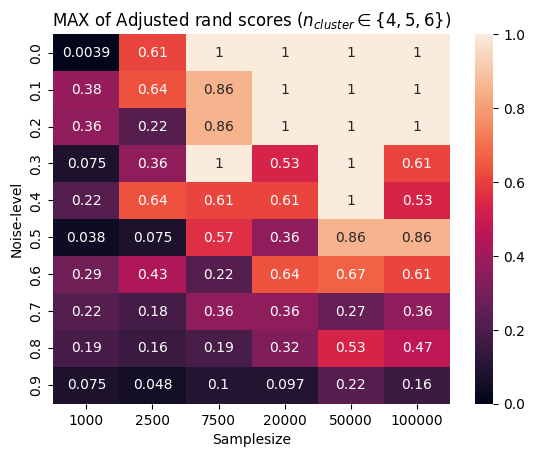

In [16]:
sns.heatmap(all_max_ar_scores,vmin=0,vmax=1, xticklabels=sample_sizes, yticklabels=noise_levels, annot=True)
plt.title("MAX of Adjusted rand scores $(n_{cluster} \in \{4,5,6\})$")
plt.xlabel("Samplesize")
plt.ylabel("Noise-level")

<>:2: SyntaxWarning: invalid escape sequence '\i'
<>:2: SyntaxWarning: invalid escape sequence '\i'
C:\Users\michi\AppData\Local\Temp\ipykernel_27584\1298229092.py:2: SyntaxWarning: invalid escape sequence '\i'
  plt.title("SUM of Adjusted rand scores $(n_{cluster} \in \mathbb{N})$")


Text(50.722222222222214, 0.5, 'Noise-level')

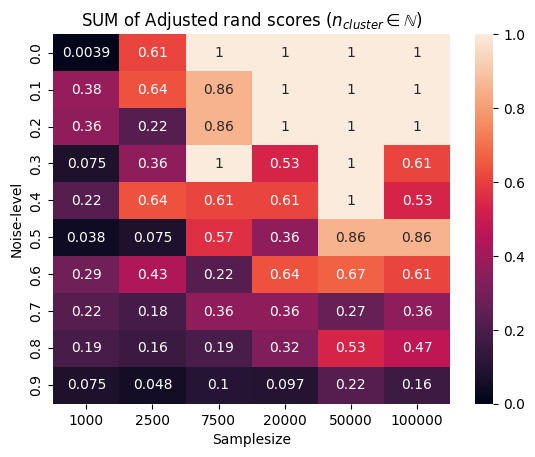

In [17]:
sns.heatmap(all_sum_ar_scores,vmin=0, xticklabels=sample_sizes, yticklabels=noise_levels, annot=True)
plt.title("SUM of Adjusted rand scores $(n_{cluster} \in \mathbb{N})$")
plt.xlabel("Samplesize")
plt.ylabel("Noise-level")

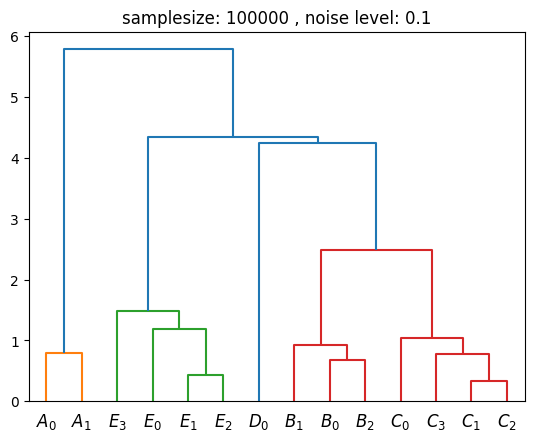

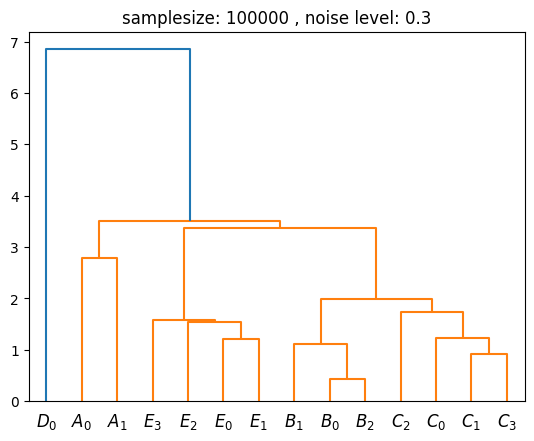

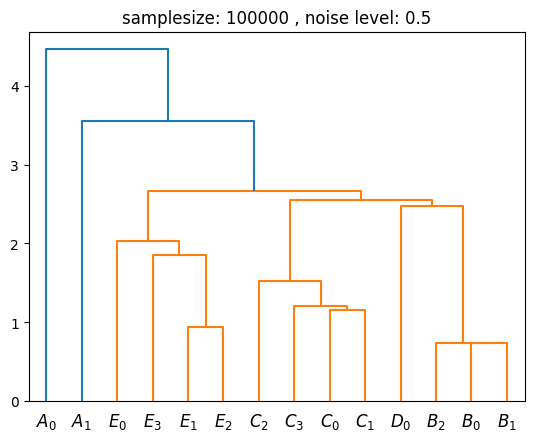

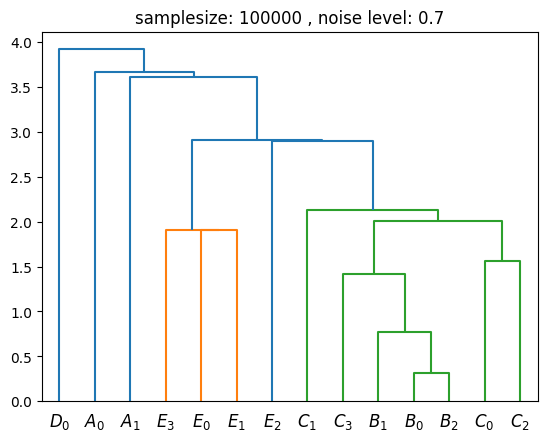

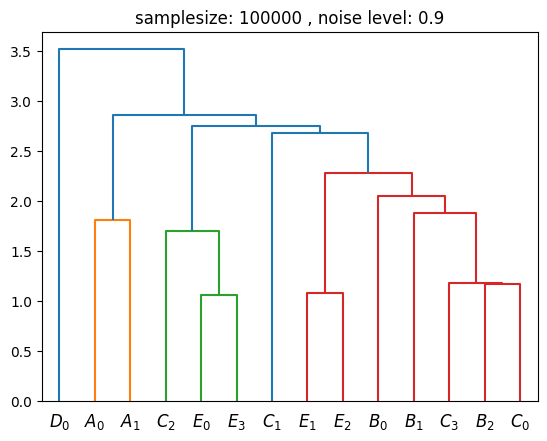

In [18]:
#select and view hierarchical clustering for one example
for nindex in [1,3,5,7,9]:
    ex_linkage=all_linkages[nindex][5]
    scipy.cluster.hierarchy.dendrogram(ex_linkage, labels= [f"${ev}$" for ev in events])
    plt.title(f"samplesize: {sample_sizes[5]} , noise level: {noise_levels[nindex]}")
    plt.show()